# Welcome

This notebook shall answer assignment_1b question 1.

# Table of Contents <a name="toc"></a>

* [Imports](#imports)
* [Global](#global)
* [Helper Functions](#helper_functions)
* [Question 1: Convergence](#convergence)
    * [Model Parameters](#model_parameters)
    * [Create the Model](#create_the_model)
    * [Run the Model](#run_the_model)
    * [Save Data Objects](#save_data_objects)
    * [Plot Model Performance](#plot_model_performance)
    * [Comparing Models](#comparing_models)
    * [Eyeballing Convergence](#eyeballing_convergence)
* [Conclusion](#conclusion)
    * [Try Test Set](#try_test_set)

# Imports <a name="imports"></a> 
[Back to top](#toc)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

from tensorflow import keras
from tqdm.keras import TqdmCallback
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
Y_train = np.load('data/Y_train.npy')
Y_test = np.load('data/Y_test.npy')
print("Data loaded")

Data loaded


# Global <a name="global"></a> 
[Back to top](#toc)

In [3]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# data objects
histories = {}

# Helper Functions <a name="helper_functions"></a> 
[Back to top](#toc)

### plot_history_object()

In [4]:
def plot_history_object(histories, model_name, history_object, max=None):   
    if max == None:
        plt.plot(histories[model_name][history_object], label='train_'+history_object)
#         plt.plot(histories[model_name]['val_'+history_object], label='val_'+history_object)
    else:
        plt.plot(histories[model_name][history_object][:max], label='train_'+history_object)
#         plt.plot(histories[model_name]['val_'+history_object][:max], label='val_'+history_object)
    plt.ylabel(history_object)
    plt.xlabel('No. epoch')
    plt.legend(loc="center right")
    plt.show()

### histories_saver()

In [5]:
# filename like 'data/histories_q1.json'
def histories_saver(histories, filename):
    histories_json = {}
    for key in histories.keys():
        histories_json[key] = histories[key].history

    with open(filename, 'w') as file:
        json.dump(histories_json, file)

    print("Histories saved")

# Question 1: Convergence  <a name="convergence"></a>
[Back to top](#toc)

<i>Design a 3-layer feedforward neural network consists of an input layer, a hidden-layer of 10 neurons having ReLU activation functions, and a linear output layer. Use mini-batch gradient descent with a batch size = 8, 𝐿2 regularization at weight decay parameter 𝛽 = 10−3 and a learning rate 𝛼 = 10−3 to train the network.

* a) Use the train dataset to train the model and plot both the train and test errors against epochs.
* b) State the approximate number of epochs where the test error is minimum and use it to stop training.
* c) Plot the predicted values and target values for any 50 test samples.</i>

### Model Parameters <a name="model_parameters"></a> 
[Back to top](#toc)

In [6]:
num_neurons = 10

weight_decay_parameter = 10e-3
regularization = keras.regularizers.l2(weight_decay_parameter)

optimizer = 'sgd'
loss = keras.losses.MeanSquaredError()
metrics = ['mse']

epochs = 500
learning_rate = 10e-3
batch_size = 8

# callbacks = [TqdmCallback(verbose=1)]
# callbacks = [TqdmCallback(verbose=1), tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)]

print("Model Parameters set")

Model Parameters set


### Create the model <a name="create_the_model"></a> 
[Back to top](#toc)

In [7]:
def create_model(num_neurons, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization, bias_regularizer=regularization),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

### Run the model <a name="run_the_model"></a> 
[Back to top](#toc)

In [8]:
model = create_model(num_neurons, regularization, optimizer, loss, metrics)

callbacks = [TqdmCallback(verbose=1)]
model_name = 'convergence_test_1'

histories[model_name] = model.fit(X_train, Y_train,
                                        epochs=epochs,
                                        verbose = 0,
                                        batch_size=batch_size,
                                        callbacks=callbacks)

Model created


In [9]:
model = create_model(num_neurons, regularization, optimizer, loss, metrics)

callbacks = [TqdmCallback(verbose=1), tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)]
model_name = 'convergence_test_2'

histories[model_name] = model.fit(X_train, Y_train,
                                        epochs=epochs,
                                        verbose = 0,
                                        batch_size=batch_size,
                                        callbacks=callbacks)

Model created


In [10]:
model = create_model(num_neurons, regularization, optimizer, loss, metrics)

callbacks = [TqdmCallback(verbose=1), tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)]
model_name = 'convergence_test_3'

histories[model_name] = model.fit(X_train, Y_train,
                                        epochs=epochs,
                                        verbose = 0,
                                        batch_size=batch_size,
                                        callbacks=callbacks)

Model created


### Save Data Objects <a name="save_data_objects"></a> 
[Back to top](#toc)

In [11]:
histories_saver(histories, "data/histories_q1.json")

Histories saved


In [33]:
with open('data/histories_q1.json') as json_file:
    histories = json.load(json_file)
print('histories reloaded')

histories reloaded


### Plot Model Performance <a name="plot_model_performance"></a> 
[Back to top](#toc)

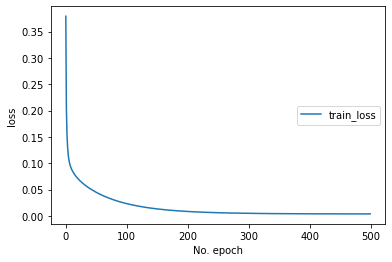

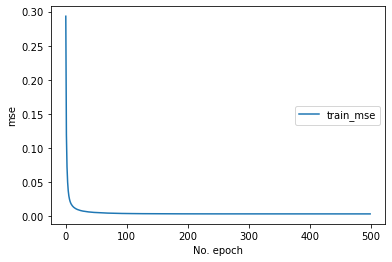

In [37]:
model_name = 'convergence_test_1'
plot_history_object(histories, model_name, 'loss')
plot_history_object(histories, model_name, 'mse')

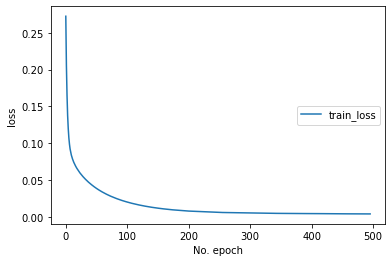

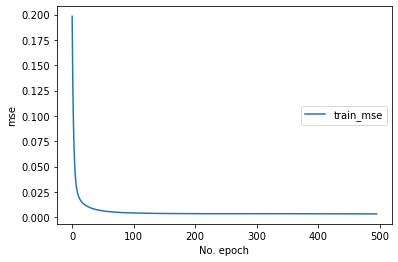

In [38]:
model_name = 'convergence_test_2'
plot_history_object(histories, model_name, 'loss')
plot_history_object(histories, model_name, 'mse')

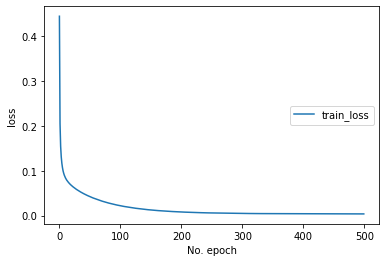

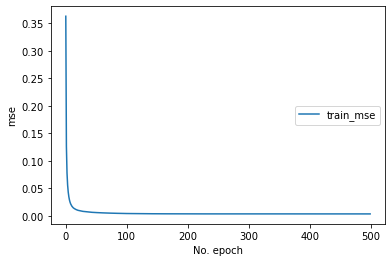

In [40]:
model_name = 'convergence_test_3'
plot_history_object(histories, model_name, 'loss')
plot_history_object(histories, model_name, 'mse')

### Comparing Models <a name="comparing_models"></a> 
[Back to top](#toc)

* <i>No early stopping - 500 epochs</i>

loss=0.00379, mse=0.00332

* <i>Early stopping - patience 5, 496 epochs</i>

loss=0.00398, mse=0.00334

* <i>Early stopping - patience 10, 500 epochs</i>

loss=0.00382, mse=0.00336

<b>loss (regularized) vs mse</b>

We can see that while the ```loss``` (regularized) takes about 200 epochs to reach convergence, the ```mse``` already has achieved convergence well before 100 epochs. It will be sufficient to determine convergence based on the ```mse``` plot

They are all pretty similar. However, graphs looked a little zoomed out. Let's zoom in

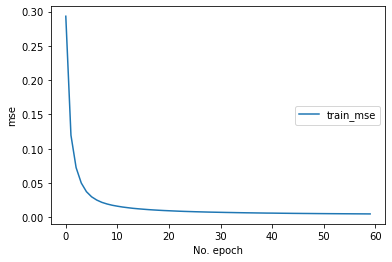

In [16]:
model_name = 'convergence_test_1'
plot_history_object(histories, model_name, 'mse', max=60)

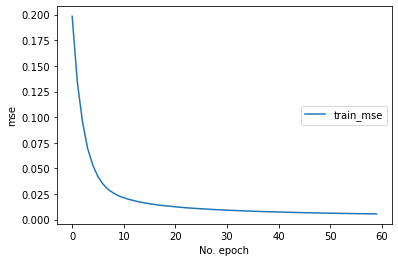

In [17]:
model_name = 'convergence_test_2'
plot_history_object(histories, model_name, 'mse', max=60)

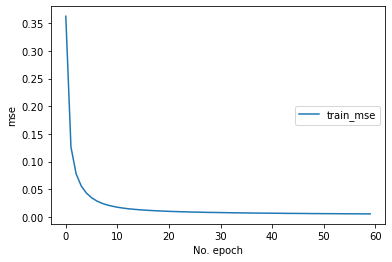

In [18]:
model_name = 'convergence_test_3'
plot_history_object(histories, model_name, 'mse', max=60)

### Eyeballing Convergence <a name="eyeballing_convergence"></a> 
[Back to top](#toc)

Only the patience was varied for these three models. Just by eyeballing these metrics produced by the three different models, it appears that 40 epochs is sufficient to achieve convergence 

# Conclusion <a name="conclusion"></a> 
[Back to top](#toc)

> 40 epochs appears to be sufficient to get a reasonable convergence for training

### Try Test Set <a name="try_test_set"></a> 
[Back to top](#toc)

We shall use ```epochs=40``` to check the performance of the model on the test set

In [20]:
epochs = 40

test_histories = {}

model = create_model(num_neurons, regularization, optimizer, loss, metrics)

callbacks = [TqdmCallback(verbose=1)]
model_name = 'test_set'

test_histories[model_name] = model.fit(X_train, Y_train,
                                        epochs=epochs,
                                        verbose = 0,
                                        batch_size=batch_size,
                                        callbacks=callbacks)

Model created


In [22]:
Y_test_pred = model.predict(X_test)
Y_test_pred = Y_test_pred.reshape(1,120)[0]

(120,)
(120, 1)


In [24]:
df_Y_test_pred = pd.DataFrame(Y_test_pred, columns =['Y_test_pred']) 
df_Y_test = pd.DataFrame(Y_test, columns =['Y_test']) 
df_scatter_y_test_pred = pd.concat([df_Y_test_pred, df_Y_test], axis=1)

In [25]:
df_scatter_y_test_pred = df_scatter_y_test_pred.sample(n=50, random_state=seed)
scatter_index = df_scatter_y_test_pred.index
print(scatter_index)
df_scatter_y_test_pred.head()

Int64Index([ 45,  79,  56,  85,  99,  41,  81, 110,  48,   2,  53,  52,  94,
             43,  80,   1,  10,  35,  47,  26,  68,  82,  37,  19,  14,  39,
             38,  63, 104, 111,   3,  75,  70, 108,  97, 115, 116,  67,  61,
             83,  84,  91,  76,  42,  21,   6,  95, 112, 103,  71],
           dtype='int64')


,Y_test_pred,Y_test
45,0.791338,0.77
79,0.389786,0.44
56,0.801506,0.75
85,0.705192,0.62
99,0.597316,0.50


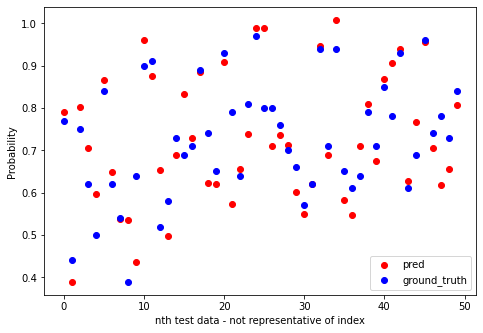

In [26]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred'], color='r', label='pred')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test'], color='b', label='ground_truth')

ax.set_xlabel('nth test data - not representative of index')
ax.set_ylabel('Probability')
ax.legend()
# ax.set_title('scatter plot')
plt.show()

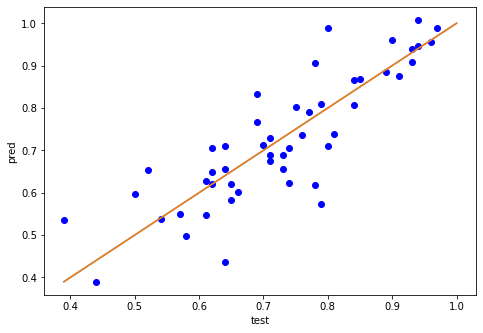

In [28]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred'], color='b')
ax.plot(np.linspace(np.min(df_scatter_y_test_pred),1,100),np.linspace(np.min(df_scatter_y_test_pred),1,100))
ax.set_xlabel('test')
ax.set_ylabel('pred')
# ax.set_title('scatter plot')
plt.show()